# 1) Descentes de gradient sans contraintes
-------------------------------------------


1-1) Soit la famille de fonction: $f(x, y) = \frac{x²}{2} + \frac{ay²}{2} ~\forall~ a \in [1; +\inf]$

Le nombre de conditionnement d'une fonction de cette famille est équivalent au nombre de conditionnement de sa Hessienne:

$H = \begin{pmatrix} 1 & 0 \\ 0 & a \end{pmatrix}$

On choisit d'utiliser la norme $l_2$ pour calculer le nombre de conditionnement de notre matrice.
Dans ce cadre, le nombre de conditionnement est égal à: $||H||_2 * ||H^{-1}||_2$

Dans notre cas, le nombre de conditionnement correspond à la plus grande valeur singulière divisée par la plus petite. Donc le nombre de conditionnement est $\frac{a}{1} = a$ avec $a \in [1; +\inf[$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import misc

In [2]:
def partial_derivative(ob_function, point, var=0):
    args = point
    def wraps(x):
        args[var] = x
        return ob_function(args)
    return misc.derivative(wraps, point[var], dx=1e-6)

In [3]:
def d_sgd(ob_function, x):
    dim = x.shape[0]
    sdescent = np.array([0]*dim, dtype=float).reshape(-1, 1)
    max_diff, imax_diff = sdescent[0], 0
    for i in range(dim):
        diff_i = abs(partial_derivative(ob_function, x, i))
        if  diff_i[0] > max_diff:
            imax_diff, max_diff = i, diff_i
    sdescent[imax_diff] = max_diff 
    return sdescent

In [7]:
def build_obj(a):
    def obj_func(x):
        return (x[0] ** 2)/2 + a*(x[1] ** 2)/2
    return obj_func


def build_derivative_obj(a):
    def derivative_obj(x):
        return x[0] + a*x[1]
    return derivative_obj

def gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None),
                     verbose=False,
                     norm=2):
    """Gradient Descent.
    
    Computes minimal value of a convex function and local minimum of none convex function.
    
    Args:
        x (ndarray): initial starting point for descent.
        ob_function: objective function of optimisation problem, has input ndarray and outputs float.
        d_direction: function computing descent direction, outputs ndarray.
        rate: function computing learning rate, outputs float.
        decay_function: function computing decay, outputs float.
        tolerance (float): slack tolerance.
        max_iter (int): upper bound on number of iterations.      
        plot_f: plotting function for iteration points.
         
    Output:
        (int, int) minimizer, minimal value.
        
    """
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    y = ob_function(x)
    while decay > tolerance and n_iter < max_iter:
        grad = d_direction(ob_function, x)
        x = x - rate(ob_function, n_iter) * grad
        tmp_y = ob_function(x)
        decay = np.linalg.norm(grad, norm)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
    if verbose:
        print(' Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}.'.format(n_iter, x.flatten(), y[0], decay))
    return ((x, y), n_iter) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

In [94]:
def eval_nb_iterations(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))
    results = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)
        derivative_obj = build_derivative_obj(a)

        start = np.array([[1], [1]], dtype=float)
        (x, y), n_iter = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        results[count, 0] = y[0]
        count+=1

    plt.plot(results, 'g', iterations, 'r', conditioning, 'b')
    plt.show()

**Pour un pas de 0.001**

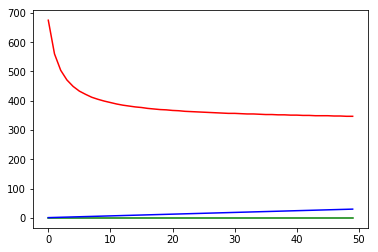

In [95]:
eval_nb_iterations(0.05, 50, 30)

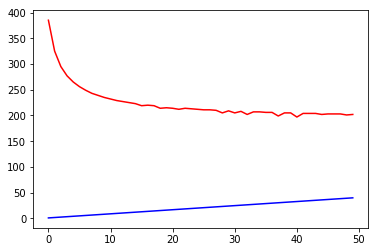

In [113]:
eval_nb_iterations(0.025, 50, 40)

On remarque deux choses pour notre famille:
- Le nombre d'itérations de la descente de gradient diminue quand le nombre de conditionnement augmente.
- A partir d'un certain nombre de conditionnement limite, la descente de gradient diverge.

On effectue maintenant des tests pour plusieurs pas différents:

**Pour un pas de 0.01:**

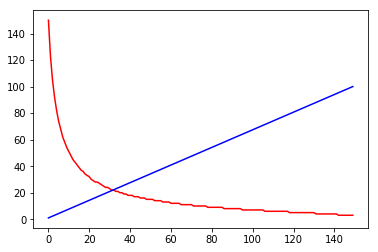

In [117]:
eval_nb_iterations(0.01, 150, 100)

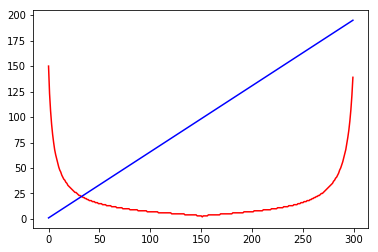

In [112]:
eval_nb_iterations(0.01, 300, 195)

**Pour un pas de 0.02:**

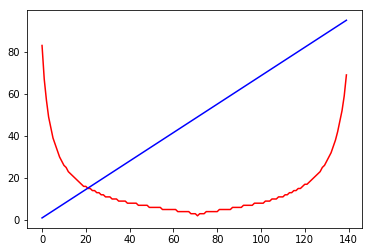

In [111]:
eval_nb_iterations(0.02, 140, 95)

**Pour un pas de 0.03:**

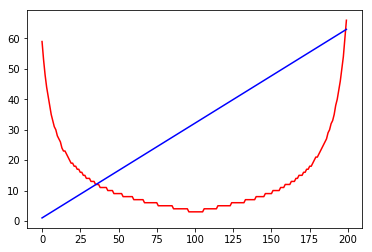

In [116]:
eval_nb_iterations(0.03, 200, 63)

On remarque que plus on diminue le nombre de conditionnement, et plus on peut avoir un pas fort. Cependant, le point objectif trouvé par une descente de gradient à pas fixe sera moins précise avec ce pas:

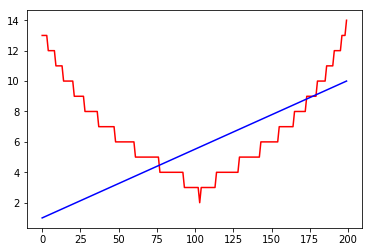

In [128]:
eval_nb_iterations(0.15, 200, 10)

In [131]:
a = 5
m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)
derivative_obj = build_derivative_obj(a)

start = np.array([[1], [1]], dtype=float)
P, n_iter = gradient_descent(start, obj, derivative_obj, 
                             rate=(lambda x, y: 0.15),
                             decay_function=(lambda x, y: abs(x[0] - y[0])),
                             tolerance=0.0001, max_iter=1000,
                             plot_f=(lambda x, y: None),
                             verbose=True)

a = 100
m = np.array([[1, 0], [0, a]])
nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)

obj = build_obj(a)
derivative_obj = build_derivative_obj(a)

start = np.array([[1], [1]], dtype=float)
P, n_iter = gradient_descent(start, obj, derivative_obj, 
                             rate=(lambda x, y: 0.01),
                             decay_function=(lambda x, y: abs(x[0] - y[0])),
                             tolerance=0.0001, max_iter=1000,
                             plot_f=(lambda x, y: None),
                             verbose=True)


 Iteration nu. = 4
 approx. = [0.0001 0.0001]
 ob value = 3.000000000000009e-08
 and decay = 2.970000000000006e-06.
 Iteration nu. = 3
 approx. = [-1.e-06 -1.e-06]
 ob value = 5.050000000000109e-11
 and decay = 5.049495000000115e-07.


On remarque que la deuxième valeur, calculée avec un nombre de conditionnement plus fort, est plus précise.

In [130]:
** Comparaison nomres L1 - L2 **


SyntaxError: invalid syntax (<ipython-input-130-a71339ceb7cd>, line 1)

In [114]:
def eval_nb_iterations_l1_l2(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)
        derivative_obj = build_derivative_obj(a)

        start = np.array([[1], [1]], dtype=float)
        P, n_iter = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        P2, n_iter2 = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: np.sqrt(x[0]**2 - y[0]**2)),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count+=1

    # red = L1-norm
    # green = L2-norm
    plt.plot(iterations, 'r', conditioning, 'b', iterations2, 'g')
    plt.show()

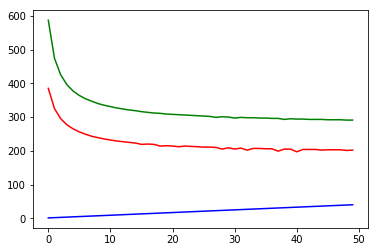

In [115]:
eval_nb_iterations_l1_l2(0.025, 50, 40)

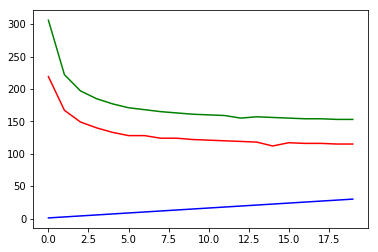

In [127]:
eval_nb_iterations_l1_l2(0.05, 20, 30)

In [106]:
def nesterov_gradient_descent(x, ob_function, d_direction, 
                     rate=(lambda x, y: 0.01),
                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                     tolerance=0.0001, max_iter=1000,
                     plot_f=(lambda x, y: None),
                     verbose=False):
    n_iter = 0
    decay = tolerance + 10  # Make sure that we get into first loop
    
    y = ob_function(x)
    y_t = x
    t = 1
    
    while decay > tolerance and n_iter < max_iter:
        curr_x = x - rate(ob_function, n_iter) * d_direction(ob_function, y_t)
        curr_t = (1 + np.sqrt(1 + 4 * t**2)) / 2
        curr_y = curr_x + ((t - 1)/curr_t) * (x - curr_x)
        
        y_t = curr_y
        x = curr_x
        t = curr_t
        
        tmp_y = ob_function(x)
        decay = decay_function(y, tmp_y)
        y = tmp_y
        n_iter += 1
        plot_f(x, y)
    if verbose:
        print(' Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}.'.format(n_iter, x.flatten(), y[0], decay))
    return ((x, y), n_iter) if decay <= tolerance else warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)

In [107]:
def eval_nb_iterations_nesterov(step, set_size=60, max_value=50):

    a_values = np.linspace(1, max_value, num=set_size)
    iterations = np.zeros((set_size, 1))
    iterations2 = np.zeros((set_size, 1))
    conditioning = np.zeros((set_size, 1))

    count = 0
    for a in a_values:
        m = np.array([[1, 0], [0, a]])
        nb_cond1 = np.linalg.norm(m, 2) * np.linalg.norm(np.linalg.inv(m), 2)
        conditioning[count, 0] = nb_cond1
    
        obj = build_obj(a)
        derivative_obj = build_derivative_obj(a)

        start = np.array([[1], [1]], dtype=float)
        P, n_iter = nesterov_gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        P2, n_iter2 = gradient_descent(start, obj, d_sgd, 
                                     rate=(lambda x, y: step),
                                     decay_function=(lambda x, y: abs(x[0] - y[0])),
                                     tolerance=0.0001, max_iter=1000,
                                     plot_f=(lambda x, y: None))
        iterations[count, 0] = n_iter
        iterations2[count, 0] = n_iter2
        count+=1

    # red = nesterov
    # green = classic
    plt.plot(iterations, 'r', conditioning, 'b', iterations2, 'g')
    plt.show()

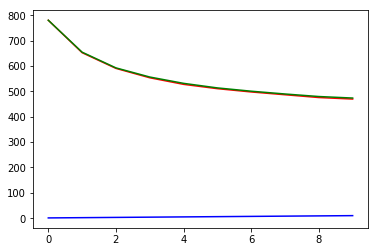

In [108]:
eval_nb_iterations_nesterov(0.01, 10, 10)

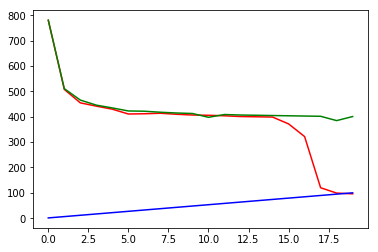

In [109]:
eval_nb_iterations_nesterov(0.01, 20, 100)

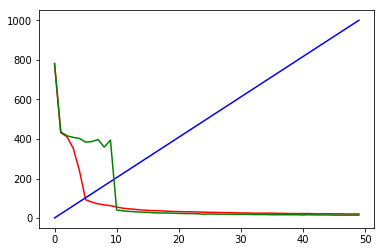

In [110]:
eval_nb_iterations_nesterov(0.01, 50, 1000)